## Introduction to COBRApy

First, we will load a model for E. coli, and then we will take a look at a few reactions and metabolites. Later, we will run linear programming optimizations and interpret the results. Then we will perform experiments and see how metabolism is affected.

To cobrapy and visualization tools, create a new conda environment and use pip:

```
conda create -n cobra matplotlib numpy scipy pandas sympy jupyterlab nodejs
conda activate cobra
pip install cobra
pip install escher
jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter labextension install escher
```

In [1]:
from cobra.io import read_sbml_model

This module can read models in SBML format. See the docs for functions to load from .mat format among others.

In [2]:
model = read_sbml_model('data/iJO1366.xml.gz')

In [3]:
model

Name,iJO1366
Memory address,0x07fce3846a040
Number of metabolites,1805
Number of reactions,2583
Number of groups,36
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm"


We see that this model contains over two thousand reactions. It is set to optimize a biomass equation.

While you can put commands in your notebook, it will be a lot easier to create an interactive terminal linked to the notebook while you figure out how to manipulate the model. Right click on the notebook name above, and select "New console for notebook." You can write in command and code blocks, and run them with `shift+enter`.

A model is an object that is a collection of metabolite objects, reaction objects, compartment objects, and methods (like optimize). You can search for metabolites or reactions with the query method.

model.metabolites calls all associated metabolites in the model. There are a lot! Let's try to find the code for fructose.

We can search for those containing fru in the name as shown below.

In [4]:
model.metabolites.query("fru")

[<Metabolite fru_c at 0x7f6f619f3490>,
 <Metabolite frulys_c at 0x7f6f619f34f0>,
 <Metabolite frulysp_c at 0x7f6f619f3550>,
 <Metabolite fruur_c at 0x7f6f619f35b0>,
 <Metabolite fru_e at 0x7f6f6188aeb0>,
 <Metabolite frulys_e at 0x7f6f6188af10>,
 <Metabolite fruur_e at 0x7f6f6188af40>,
 <Metabolite fru_p at 0x7f6f61785f10>,
 <Metabolite frulys_p at 0x7f6f61785f70>,
 <Metabolite fruur_p at 0x7f6f61785fa0>]

Ok, this narrows it down. But it still isn't clear exactly what each code is. Each metabolite has a list of attributes, including name. Let's use a list comprehension iterate through the results in the cell above and print the name for each.

In [5]:
[print(meta,":",meta.name) for meta in model.metabolites.query("fru")]

fru_c : D-Fructose
frulys_c : Fructoselysine
frulysp_c : Fructoselysine Phosphate
fruur_c : D-Fructuronate
fru_e : D-Fructose
frulys_e : Fructoselysine
fruur_e : D-Fructuronate
fru_p : D-Fructose
frulys_p : Fructoselysine
fruur_p : D-Fructuronate


[None, None, None, None, None, None, None, None, None, None]

We see that fru_c, fru_e, and fru_p are both fructose. What is the difference? "_c", "_e", and "_p" tell us that one represents fructose in the cystoplasm, extracellularly, and in the periplasm. Let's look up the reactions that involve fructose in the cytoplasm. These are listed as an attribute with the metabolite name.

In [6]:
model.metabolites.fru_c.reactions

frozenset({<Reaction F6PP at 0x7f6f60cc5cd0>,
           <Reaction FFSD at 0x7f6f60bfcf70>,
           <Reaction HEX7 at 0x7f6f609bbee0>,
           <Reaction XYLI2 at 0x7f6f601d7f70>})

Ok, four reactions, but the names aren't always so useful. Let's use another loop to get names. This time, I'm using a for loop, but really it is the same as list comprehension.

In [7]:
for reaction in model.metabolites.fru_c.reactions:
    print(reaction, reaction.name)

XYLI2: glc__D_c <=> fru_c Xylose isomerase
F6PP: f6p_c + h2o_c --> fru_c + pi_c D-fructose 6-phosphate phosphatase
HEX7: atp_c + fru_c --> adp_c + f6p_c + h_c Hexokinase (D-fructose:ATP)
FFSD: h2o_c + suc6p_c --> fru_c + g6p_c Beta-fructofuranosidase


We see some nice transformations here, but how does this link to fructose in the periplasm? Let's see what reactions that state is involved in.

In [8]:
for reaction in model.metabolites.fru_p.reactions:
    print(reaction, reaction.name)

FRUptspp: fru_p + pep_c --> f1p_c + pyr_c D-fructose transport via PEP:Pyr PTS (periplasm)
FRUtex: fru_e <=> fru_p D-fructose transport via diffusion (extracellular to periplasm)
FRUpts2pp: fru_p + pep_c --> f6p_c + pyr_c Fructose transport via PEP:Pyr PTS (f6p generating) (periplasm)


These reactions tell us something interesting about E. coli: there are no direct fructose transporters! Instead, we see in the FRUptspp and FRUpts2pp reaction that periplasmic fructose is transported into the cytosol coincident with its phosphorylation. This uses cytoplasmic phosphoenylpyruvate (PEP). For completeness, we should expect to see a zero-order exchange reaction introducing fru_e into the system. Let's check.

In [10]:
for reaction in model.metabolites.fru_e.reactions:
    print(reaction, reaction.name)

FRUtex: fru_e <=> fru_p D-fructose transport via diffusion (extracellular to periplasm)
EX_fru_e: fru_e -->  D-Fructose exchange


Many models use negative values for metabolite uptake into the system, so here if the flux for fru_e --> was -10, it means fructose is entering the system.

# Performing flux balance analysis

Let's take a closer look at the default objective function for this model, and then run a simulation and see some fit fluxes.

In [9]:
model.objective.expression

1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1

We seem to be optimizing for a core biomass equation. Notice how we are optimizing for the net forward direction. Let's take a closer look at what the biomass equation is:

In [11]:
model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.reaction

'0.000223 10fthf_c + 2.6e-05 2fe2s_c + 0.000223 2ohph_c + 0.00026 4fe4s_c + 0.513689 ala__L_c + 0.000223 amet_c + 0.295792 arg__L_c + 0.241055 asn__L_c + 0.241055 asp__L_c + 54.124831 atp_c + 0.000122 bmocogdp_c + 2e-06 btn_c + 0.005205 ca2_c + 0.005205 cl_c + 0.000576 coa_c + 2.5e-05 cobalt2_c + 0.133508 ctp_c + 0.000709 cu2_c + 0.09158 cys__L_c + 0.026166 datp_c + 0.027017 dctp_c + 0.027017 dgtp_c + 0.026166 dttp_c + 0.000223 fad_c + 0.006715 fe2_c + 0.007808 fe3_c + 0.26316 gln__L_c + 0.26316 glu__L_c + 0.612638 gly_c + 0.215096 gtp_c + 48.601527 h2o_c + 0.094738 his__L_c + 0.290529 ile__L_c + 0.195193 k_c + 0.019456 kdo2lipid4_e + 0.450531 leu__L_c + 0.343161 lys__L_c + 0.153686 met__L_c + 0.008675 mg2_c + 0.000223 mlthf_c + 0.000691 mn2_c + 7e-06 mobd_c + 0.013894 murein5px4p_p + 0.001831 nad_c + 0.000447 nadp_c + 0.013013 nh4_c + 0.000323 ni2_c + 0.017868 pe160_c + 0.045946 pe160_p + 0.054154 pe161_c + 0.02106 pe161_p + 0.185265 phe__L_c + 0.000223 pheme_c + 0.221055 pro__L_c + 0

Complicated! Biomass functions like this are very carefully considered and tuned to match experimental conditions. This expression captures what it takes for *E. coli* to grow and divide. 

Notice how this equation is not mass balanced! Metabolites like amino acids (met, his, ile, gln, etc.) are consumed and are lost from the system.

## Constraints

Ok, so our stoichiometry matrix derives from the reactions, our objective function is defined. What about our constraints? These are encoded in the reaction objects. You can view or modify them. Let's look at the bounds for the F6PP reaction

In [14]:
model.reactions.F6PP.bounds = (0, 0)
model.reactions.F6PP.bounds

(0, 2000)

1000 is a fairly high upper bound, practically unbounded. Scroll up a few blocks to where we looked at the F6PP reaction. Notice that it is irreversible? That is consistent with the lower bound 0.

For fun, set the lower bound to a negative number (you can use the `=` operator and input a tuple like (-10,1000). Then, view the reaction again with `model.reactions.F6PP.reaction` and see what happens.

## Media

The growth media or surrounding environment can be defined by exchange reactions. You can view these reactions as below.

In [4]:
model.medium

{'EX_ca2_e': 1000.0,
 'EX_cbl1_e': 0.01,
 'EX_cl_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_h_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_slnt_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_zn2_e': 1000.0}

We see that many micronutrients are in abundance. Glucose, however, is limiting with 10, and there is no other carbon source supplied. Importantly, O2 is not limiting, so this is aerobic growth. EX_cbl1_e is also interesting, let's see what this is.

In [5]:
model.metabolites.cbl1_e.name

'Cob(I)alamin'

Cobalamin is vitamin B12.

Enough chit-chat, let's optimize this cell.

In [8]:
solution = model.optimize() # GLPK, gurobi, IBM-CPLEX

In [14]:
solution

,fluxes,reduced_costs
DM_4crsol_c,0.000219,0.000000
DM_5drib_c,0.000221,0.000000
DM_aacald_c,0.000000,0.000000
DM_amob_c,0.000002,0.000000
DM_mththf_c,0.000440,0.000000
...,...,...
ZN2abcpp,0.000000,-0.008295
ZN2t3pp,0.000000,-0.002074
ZN2tpp,0.000335,0.000000
ZNabcpp,0.000000,-0.008295


The solution object contains fluxes, shadow costs, and reduced costs for each reaction. We see that the objective solved to 0.982. That's cool, but without some graphs or variables, it doesn't tell us much.

If you installed escher and used the Jupyter widget, we can plot our fluxes.

In [6]:
import escher

In [5]:
escher.list_available_maps() # Let's see what models come with escher by default

[{'organism': 'Saccharomyces cerevisiae',
  'map_name': 'iMM904.Central carbon metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Inositol retinol metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Glycolysis TCA PPP'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Tryptophan metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Carbohydrate metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Amino acid metabolism (partial)'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Nucleotide metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid biosynthesis (saturated)'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Nucleotide and histidine biosynthesis'},
 {'organism': 'Escherichia coli', 'map_name': 'e_coli_core.Core metabolism'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Central metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid beta-oxidation'}

In [9]:
escher.Builder(map_name='iJO1366.Central metabolism',
                   model = model,
                   reaction_data=dict(solution.fluxes))

Builder(reaction_data={'DM_4crsol_c': 0.00021906891423811625, 'DM_5drib_c': 0.0002210336578635664, 'DM_aacald_…

Pretty cool, eh? Let's try something. What if the cell didn't have oxygen?

In [10]:
newmodel = model.copy()


In [11]:
medium = newmodel.medium # copying to new object
medium["EX_o2_e"] = 0.0 # setting value to zero (python dicitionary)
newmodel.medium = medium

newmodel.medium

{'EX_ca2_e': 1000.0,
 'EX_cbl1_e': 0.01,
 'EX_cl_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_h_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_slnt_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_zn2_e': 1000.0}

In [12]:
anaerobic = newmodel.optimize()

In [13]:
anaerobic

,fluxes,reduced_costs
DM_4crsol_c,5.385485e-05,0.000000
DM_5drib_c,1.620475e-04,0.000000
DM_aacald_c,0.000000e+00,0.000000
DM_amob_c,4.830031e-07,0.000000
DM_mththf_c,1.081927e-04,0.000000
...,...,...
ZN2abcpp,0.000000e+00,-0.022105
ZN2t3pp,0.000000e+00,-0.005526
ZN2tpp,8.235203e-05,0.000000
ZNabcpp,0.000000e+00,-0.022105


Growth rate took a big hit! Let's map it

In [14]:
escher.Builder(map_name='iJO1366.Central metabolism',
                   reaction_data=dict(anaerobic.fluxes))

Builder(reaction_data={'DM_4crsol_c': 5.3854847232670166e-05, 'DM_5drib_c': 0.00016204754481220483, 'DM_aacald…

Pretty cool. We see a huge increase in glycolysis. Makes sense!

Now let's extract specific fluxes from the simulation and see how they vary with constraints. Let's test the effect of glucose availability on the media. Let's also see how much oxygen is sucked up by the cells, and how much acetate and lactate are secreted from the cell.

In [16]:
medium = model.medium # glucose in medium
testvalues = [0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 200, 500, 1000] # test values
output = [] # empty lists to start collecting output
oxygen = []
acetate = []
lactate = []
with model: # doesn't overwrite the original model
    for i in testvalues: 
        medium['EX_glc__D_e'] = i # redefine glucose uptake
        model.medium = medium
        solution = model.optimize() # solution an object with fluxes and reaction names
        output.append(solution.objective_value) # append method
        oxygen.append(-solution.fluxes['EX_o2_e']) # notice the minus sign
        acetate.append(solution.fluxes['EX_ac_e'])
        lactate.append(solution.fluxes['EX_lac__L_e'])

In [17]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Media composition and growth')

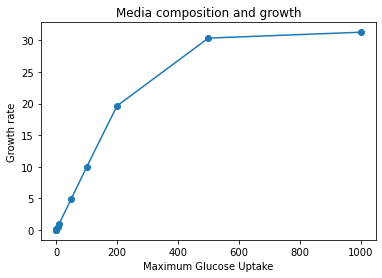

In [18]:
plt.plot(testvalues, output, "o-")
plt.xlabel("Maximum Glucose Uptake")
plt.ylabel("Growth rate")
plt.title("Media composition and growth")

Text(0.5, 1.0, 'Media composition and oxygen consumption')

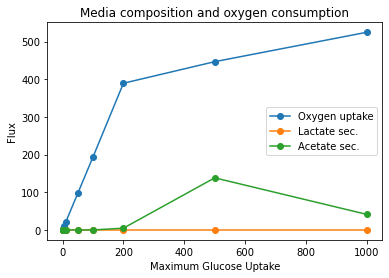

In [19]:
plt.plot(testvalues, oxygen, "o-", label = "Oxygen uptake")
plt.plot(testvalues, lactate, "o-", label = "Lactate sec.")
plt.plot(testvalues, acetate, "o-", label = "Acetate sec.")
plt.legend()
plt.xlabel("Maximum Glucose Uptake")
plt.ylabel("Flux")
plt.title("Media composition and oxygen consumption")

Let's try something else. Let's keep the glucose availability in the media constant, and then force the cells to uptake increasing amounts of oxygen. Oxygen is good, right?

In [20]:
#medium = model.medium
testvalues = [0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 200, 250, 260, 280, 300]
output = []
oxygen = []
gluuptake = []
with model: # doesn't overwrite the original model
    for i in testvalues:
        model.reactions.EX_o2_e.bounds = (-i, -i) # Negative means O2 is entering the cell
        solution = model.optimize()
        output.append(solution.objective_value)

Text(0.5, 1.0, 'Oxygen uptake and growth')

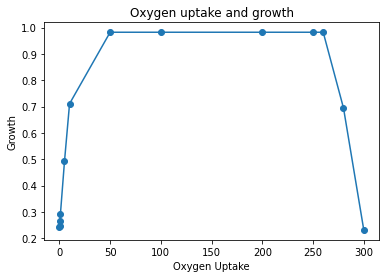

In [21]:
plt.plot(testvalues, output, "o-")
plt.xlabel("Oxygen Uptake")
plt.ylabel("Growth")
plt.title("Oxygen uptake and growth")

In [22]:
from cobra.flux_analysis import production_envelope
prod_env = production_envelope(
    model, ["EX_o2_e"], objective="EX_ac_e", carbon_sources="EX_glc__D_e")

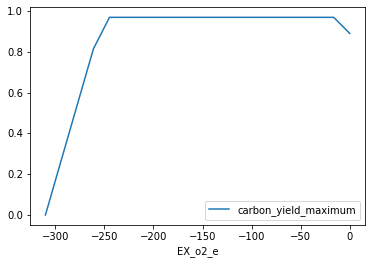

In [23]:
prod_env.plot(
    kind='line', x='EX_o2_e', y='carbon_yield_maximum');

In [ ]:
prod_env

The production envelope gives us the same information as our manual experiment. Note that the sign for glucose uptake is inverted in the COBRA function; you'll see that I added a negative sign in my code to provide opposite values. The exchange reaction has metabolites leaving the environment, so they will appear negative when they enter.